In [150]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from collections import Counter

sns.reset_orig()


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

np.random.seed(seed)

In [151]:
def tree_function(mdl, X_tr, y_tr, X_te, y_te, xxx=None, yyy=None, silent=False):

    mdl.fit(X_tr, y_tr)

    y_pred = mdl.predict(X_te)

    if silent == False:
        mesh_data = c_[xxx.ravel(), yyy.ravel()]
        Z = np.asarray(mdl.predict(mesh_data)).reshape(xx.shape)

        plt.figure(figsize=(10, 10))
        plt.contourf(xx, yy, Z, alpha=0.6, cmap = 'ocean')
        plt.scatter(X_te[:, 0], X_te[:, 1], c=y_te)

        cm_model = confusion_matrix(y_te, y_pred)
        tn_model = cm_model[0][0]
        fn_model = cm_model[0][1]
        tp_model = cm_model[1][1]
        fp_model = cm_model[1][0]
        ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

        fpr, tpr, roc_auc = roc_curve(y_te, mdl.predict(X_te))

        rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
        rok_model.plot()


        print("Czulosc:", tp_model/(tp_model + fn_model))
        print("Swoistosc:", tn_model/(tn_model + fp_model))
        print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

        print("ROC auc:", roc_auc_score(y_test, y_pred))
        print("F1 score:", f1_score(y_test, y_pred))
        print("BA score:", balanced_accuracy_score(y_test, y_pred))



In [152]:
class MyDecisionTreeClassifier():
    class Node():
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.info_gain = info_gain

            self.value = value

    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None

        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):

        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        if num_samples >= self.min_samples_split and curr_depth < self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if len(best_split) != 0:
                if best_split["info_gain"] > 0:
                    left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                    right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                    return self.Node(best_split["feature_index"], best_split["threshold"],
                                     left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return self.Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                # dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                dataset_left = dataset[dataset[:, feature_index] <= threshold]
                dataset_right = dataset[dataset[:, feature_index] > threshold]
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    # y, left_y, right_y =
                    curr_info_gain = self.information_gain(dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1],
                                                           "gini")

                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):
        # def split(self, X, Y, feature_index, threshold):
        X_left = []
        X_right = []
        for i, row in enumerate(dataset):
            if row[feature_index] <= threshold:
                X_left.append(row)
            else:
                X_right.append(row)

        return np.array(X_left), np.array(X_right)

    def information_gain(self, parent, l_child, r_child, mode="gini"):

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        return gain

    def entropy(self, y):

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    def calculate_leaf_value(self, Y):

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_" + str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):

        # dataset = np.concatenate((X, Y), axis=1)
        dataset = np.column_stack((X, Y))
        self.root = self.build_tree(dataset)

    def predict(self, X):

        pred = np.empty(shape=len(X))

        for i in range(len(X)):
            pred[i] = self.make_prediction(X[i], self.root)

        return pred

        # preditions = [self.make_prediction(x, self.root) for x in X]
        # return preditions

    def make_prediction(self, x, tree):

        if tree.value is not None:
            return tree.value

        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [153]:
# class MyRandomForest:
#     def __init__(self, n_estimators, min_samples_split, max_depth):
#         self.n_estimators = n_estimators
#         self.min_sample_split = min_samples_split
#         self.max_depth = max_depth
#         self.estimators = []
#         pass
#
#     def fit(self, X, y):
#         self.estimators = [MyDecisionTreeClassifier(self.min_sample_split, self.max_depth) for _ in range(self.n_estimators)]
#
#         mydata = np.column_stack((X, y))
#
#         for e in self.estimators:
#             sample_idx = np.random.choice(X.shape[0], X.shape[0])
#             # print(X.shape[0])
#             # print(sample_idx)
#             e.fit(X[sample_idx], y[sample_idx])
#
#         pass
#
#
#     def predict(self, X):
#         all = []
#         for e in self.estimators:
#             all.append([int(xxx) for xxx in e.predict(X)])
#         all = np.array(all).T
#
#         return np.array([np.argmax(np.bincount(pred)) for pred in all])
#
#


In [154]:
from sklearn.tree import DecisionTreeClassifier


class MyRandomForest:
    def __init__(self, n_estimators, min_samples_split, max_depth):
        self.n_estimators = n_estimators
        self.min_sample_split = min_samples_split
        self.max_depth = max_depth
        self.estimators = []
        pass

    def fit(self, X, y):
        self.estimators = [DecisionTreeClassifier(min_samples_split=self.min_sample_split, max_depth=self.max_depth) for _ in range(self.n_estimators)]

        mydata = np.column_stack((X, y))

        for e in self.estimators:
            sample_idx = np.random.choice(X.shape[0], X.shape[0])
            # print(X.shape[0])
            # print(sample_idx)
            e.fit(X[sample_idx], y[sample_idx])

        pass


    def predict(self, X):
        all = []
        for e in self.estimators:
            all.append([int(xxx) for xxx in e.predict(X)])
        all = np.array(all).T

        return np.array([np.argmax(np.bincount(pred)) for pred in all])




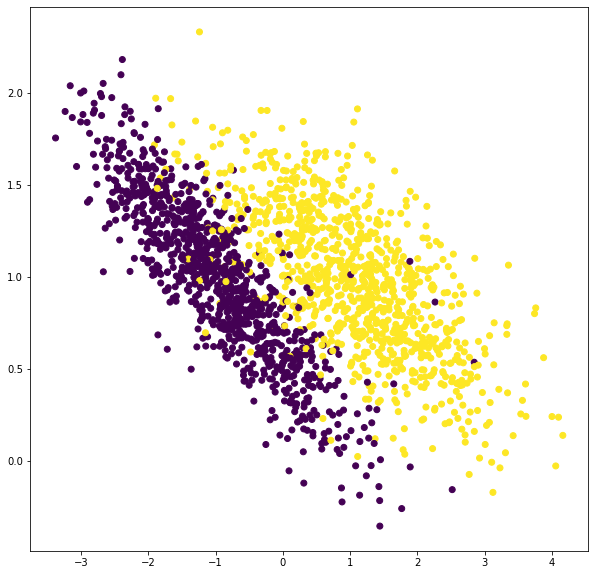

In [155]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

# y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czulosc: 0.8794642857142857
Swoistosc: 0.7969348659003831
Accuracy: 0.8350515463917526
ROC auc: 0.8365531914893617
F1 score: 0.8312236286919831
BA score: 0.8365531914893617
Czas wykonania sklearn: 3.3985514999949373


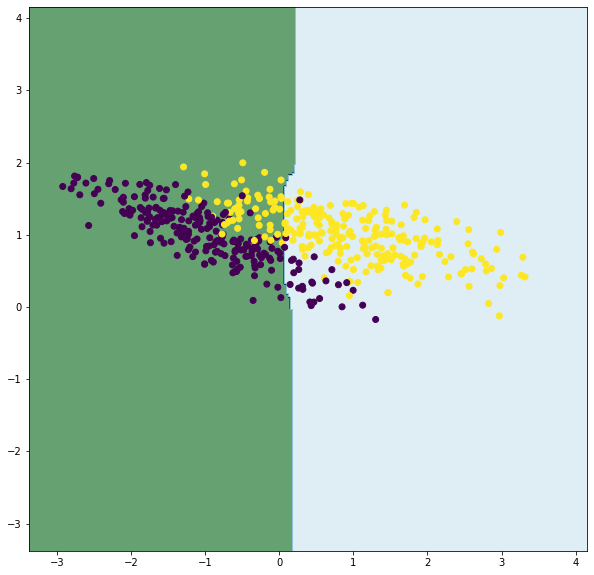

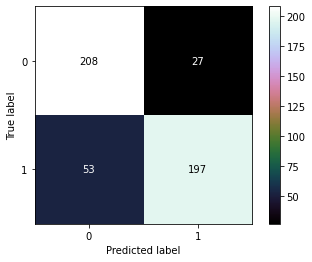

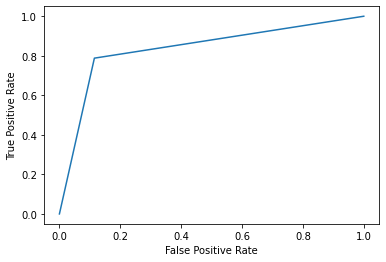

In [156]:
model = RandomForestClassifier(n_estimators=100, max_depth=1, min_samples_split=2, random_state=seed)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

Czulosc: 0.8601694915254238
Swoistosc: 0.8112449799196787
Accuracy: 0.8350515463917526
ROC auc: 0.8357872340425533
F1 score: 0.8353909465020577
BA score: 0.8357872340425532
Czas wykonania moj: 17.244147199991858


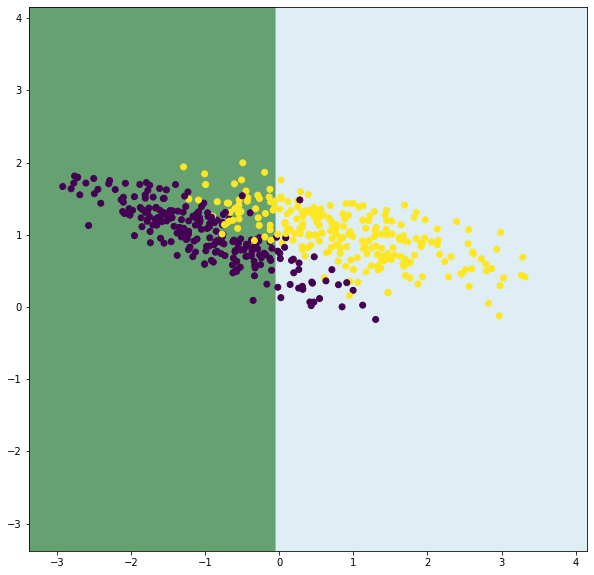

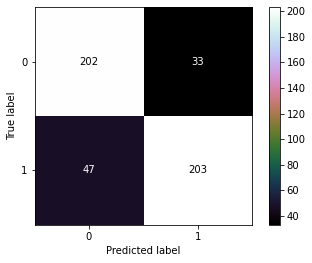

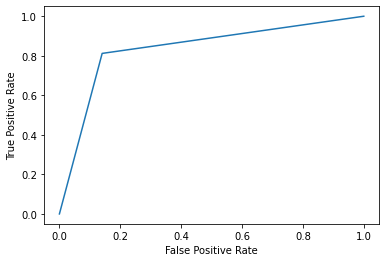

In [157]:
model = MyRandomForest(n_estimators=100, max_depth=1, min_samples_split=2)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania moj:', (time.perf_counter() - czasek))

Czulosc: 0.8903508771929824
Swoistosc: 0.8171206225680934
Accuracy: 0.8515463917525773
ROC auc: 0.8528085106382979
F1 score: 0.8493723849372385
BA score: 0.8528085106382979
Czas wykonania sklearn: 3.456762499990873


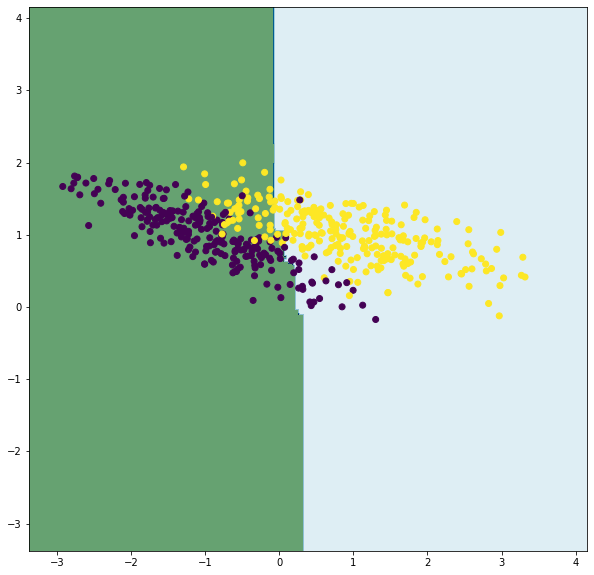

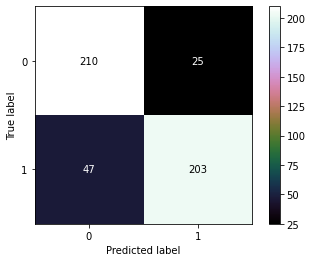

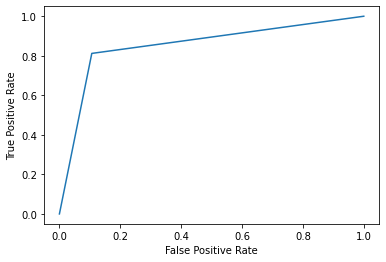

In [158]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_split=2, random_state=seed)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

Czulosc: 0.8873239436619719
Swoistosc: 0.7757352941176471
Accuracy: 0.8247422680412371
ROC auc: 0.8269361702127659
F1 score: 0.816414686825054
BA score: 0.826936170212766
Czas wykonania moj: 16.96218339999905


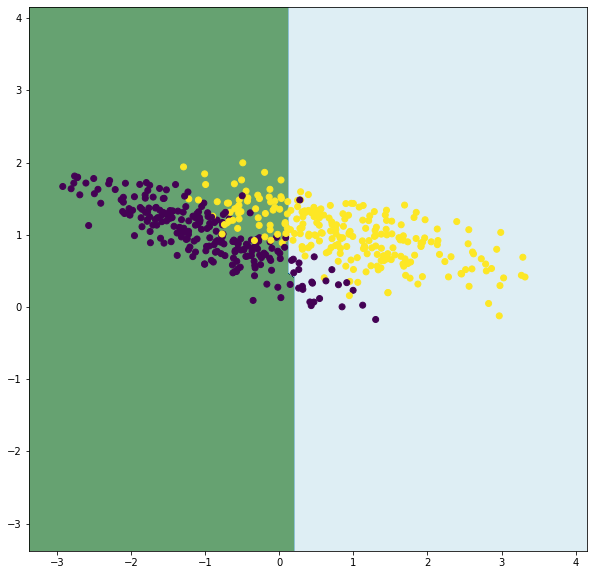

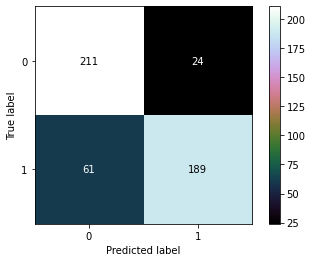

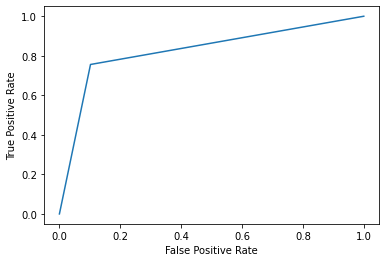

In [159]:
model = MyRandomForest(n_estimators=100, max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania moj:', (time.perf_counter() - czasek))

Czulosc: 0.9588477366255144
Swoistosc: 0.9297520661157025
Accuracy: 0.9443298969072165
ROC auc: 0.9447234042553192
F1 score: 0.9452332657200813
BA score: 0.9447234042553192
Czas wykonania sklearn: 4.42293579998659


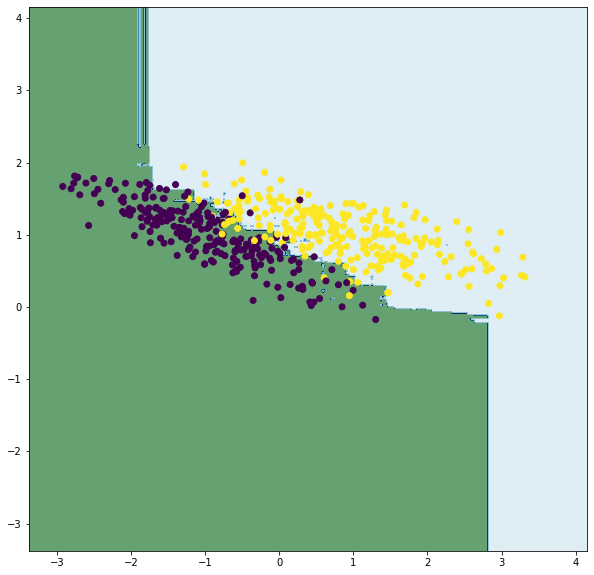

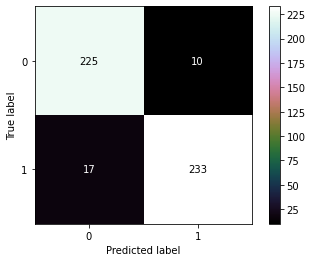

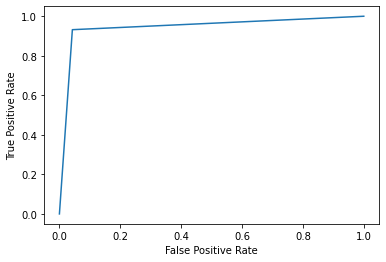

In [160]:
model = RandomForestClassifier(n_estimators=100, max_depth=samples, min_samples_split=2, random_state=seed)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

Czulosc: 0.9469387755102041
Swoistosc: 0.925
Accuracy: 0.9360824742268041
ROC auc: 0.9363404255319149
F1 score: 0.9373737373737374
BA score: 0.936340425531915
Czas wykonania moj: 18.539588699990418


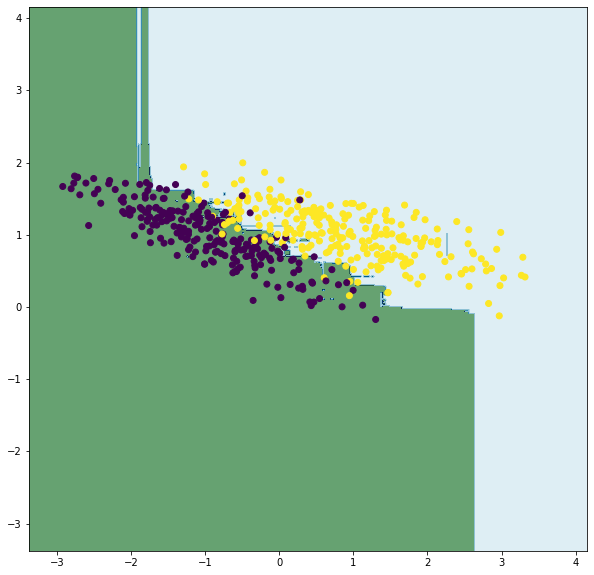

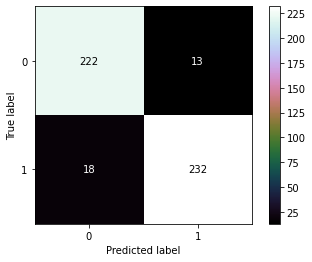

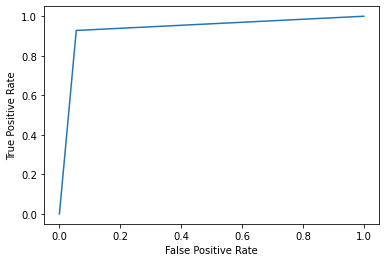

In [161]:
model = MyRandomForest(n_estimators=100, max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania moj:', (time.perf_counter() - czasek))

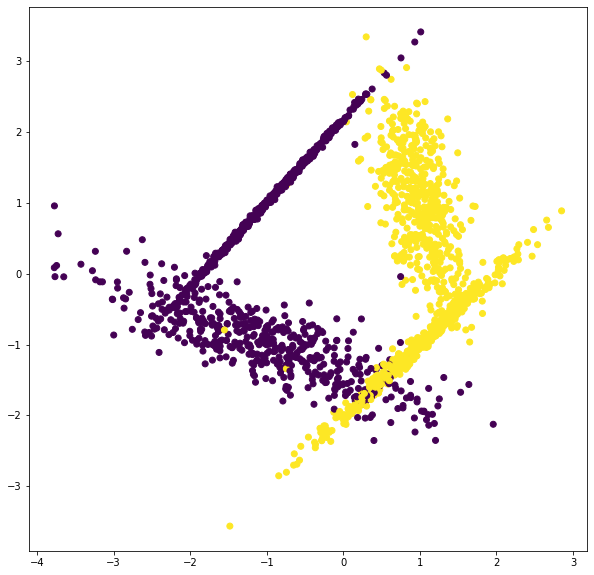

In [162]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=2)

# y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czulosc: 0.951417004048583
Swoistosc: 0.9705882352941176
Accuracy: 0.9608247422680413
ROC auc: 0.9608458320579533
F1 score: 0.9611451942740287
BA score: 0.9608458320579533
Czas wykonania sklearn: 3.249260000011418


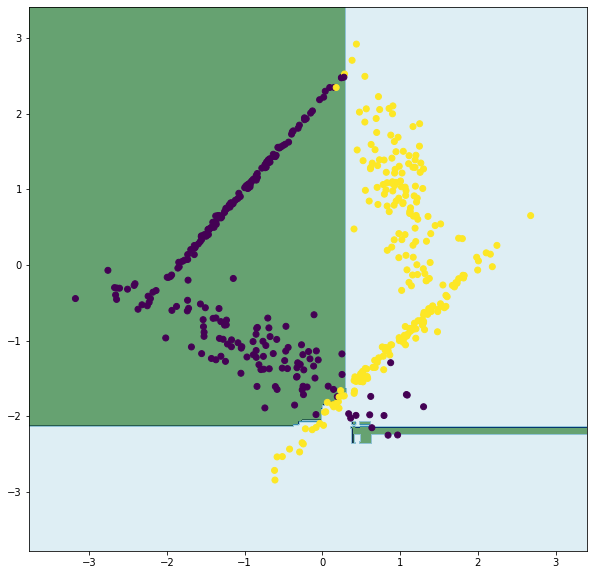

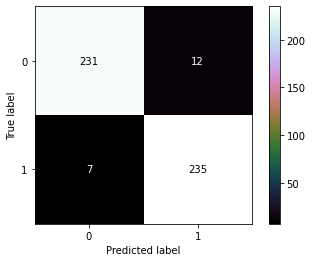

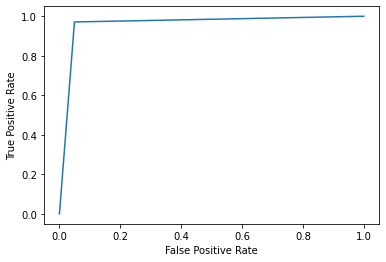

In [163]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_split=2, random_state=seed)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))


Czulosc: 0.9556451612903226
Swoistosc: 0.9789029535864979
Accuracy: 0.9670103092783505
ROC auc: 0.9670356766316363
F1 score: 0.9673469387755103
BA score: 0.9670356766316361
Czas wykonania moj: 15.712808399985079


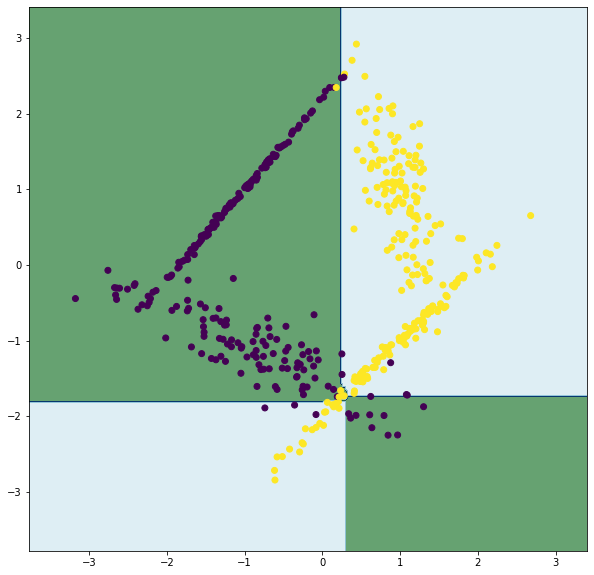

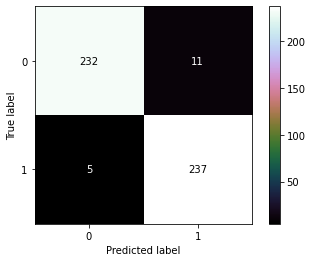

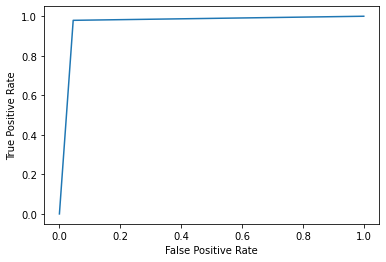

In [164]:
model = MyRandomForest(n_estimators=100, max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania moj:', (time.perf_counter() - czasek))


Czulosc: 0.9916317991631799
Swoistosc: 0.9796747967479674
Accuracy: 0.9855670103092784
ROC auc: 0.9855541951501547
F1 score: 0.9854469854469855
BA score: 0.9855541951501547
Czas wykonania sklearn: 4.028430800011847


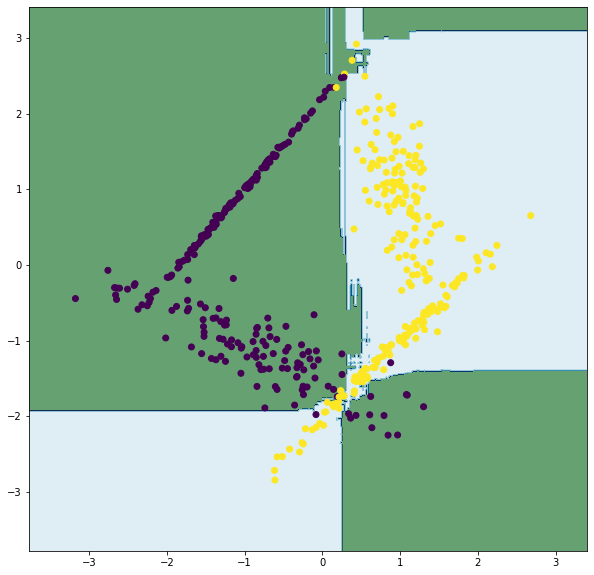

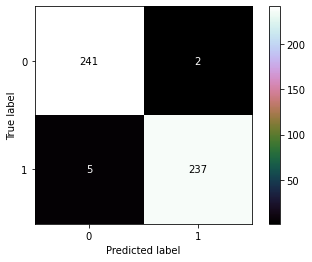

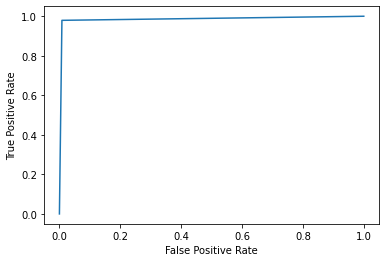

In [165]:
model = RandomForestClassifier(n_estimators=100, max_depth=samples, min_samples_split=2, random_state=seed)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))


Czulosc: 0.9916317991631799
Swoistosc: 0.9796747967479674
Accuracy: 0.9855670103092784
ROC auc: 0.9855541951501547
F1 score: 0.9854469854469855
BA score: 0.9855541951501547
Czas wykonania moj: 17.67482220000238


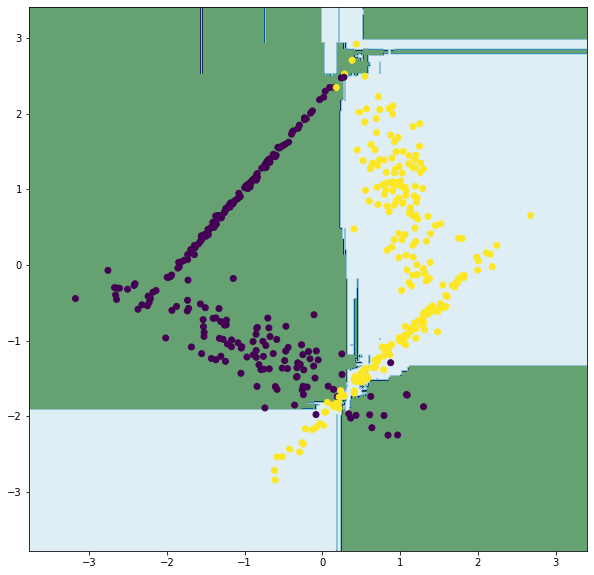

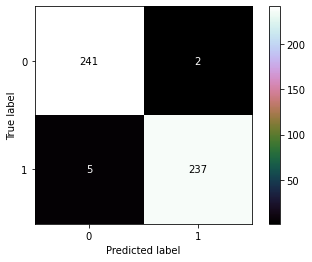

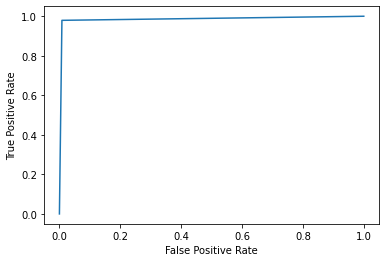

In [166]:
model = MyRandomForest(n_estimators=100, max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania moj:', (time.perf_counter() - czasek))

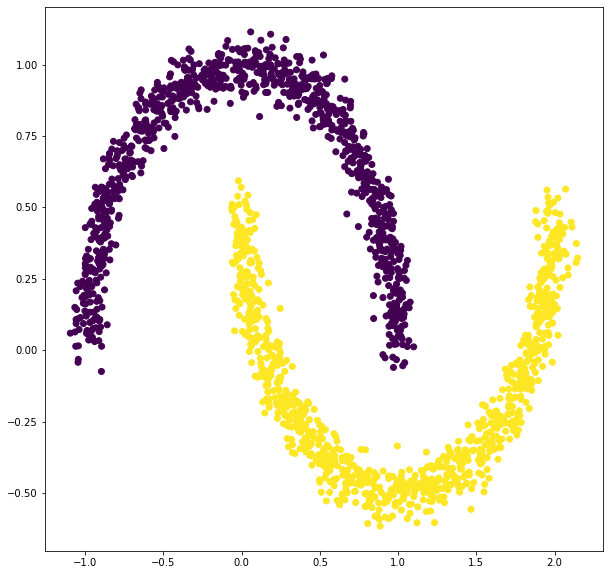

In [167]:
# X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
X, y = datasets.make_moons(random_state=seed, n_samples=samples, noise=0.05)

# y[y == 0] = -1

poly = PolynomialFeatures(degree=4, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

# X_train = my_normalize(X_train)
# X_test = my_normalize(X_test)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)


plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czulosc: 0.8943396226415095
Swoistosc: 0.9727272727272728
Accuracy: 0.9298969072164949
ROC auc: 0.9298030813182327
F1 score: 0.9330708661417323
BA score: 0.9298030813182329
Czas wykonania sklearn: 1.7201771000109147


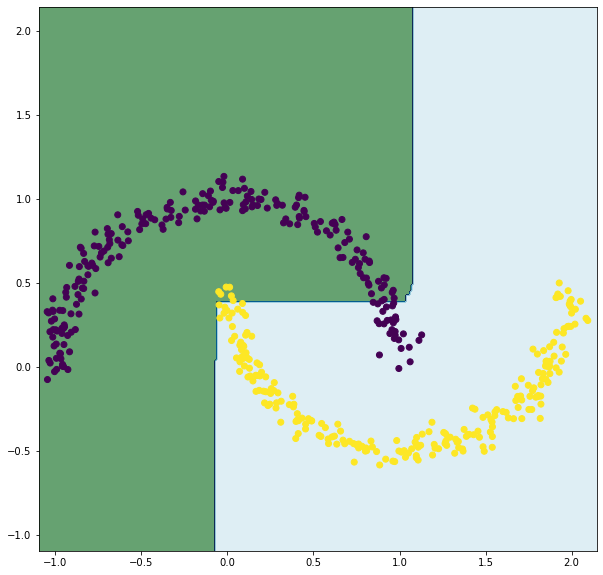

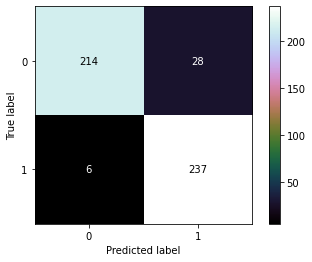

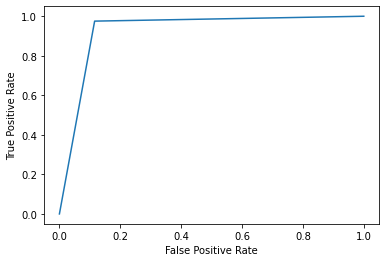

In [168]:
model = RandomForestClassifier(n_estimators=100, max_depth=1, min_samples_split=2, random_state=seed)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

Czulosc: 0.8076923076923077
Swoistosc: 0.8533333333333334
Accuracy: 0.8288659793814434
ROC auc: 0.8287929803081318
F1 score: 0.8349900596421471
BA score: 0.8287929803081318
Czas wykonania moj: 3.643764899985399


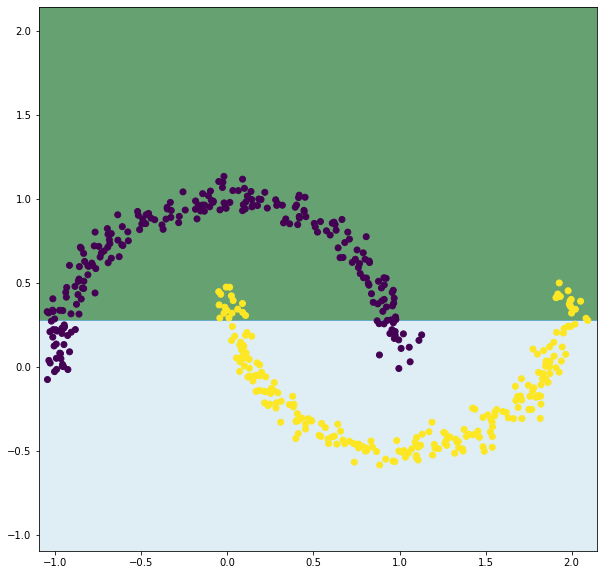

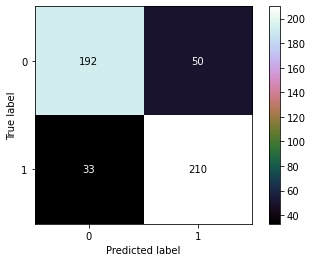

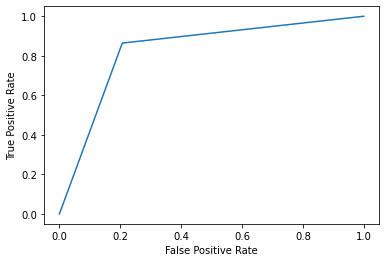

In [169]:
model = MyRandomForest(n_estimators=100, max_depth=1, min_samples_split=2)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania moj:', (time.perf_counter() - czasek))

Czulosc: 0.8851851851851852
Swoistosc: 0.9813953488372092
Accuracy: 0.9278350515463918
ROC auc: 0.9277199605482433
F1 score: 0.9317738791423003
BA score: 0.9277199605482433
Czas wykonania sklearn: 2.137835300003644


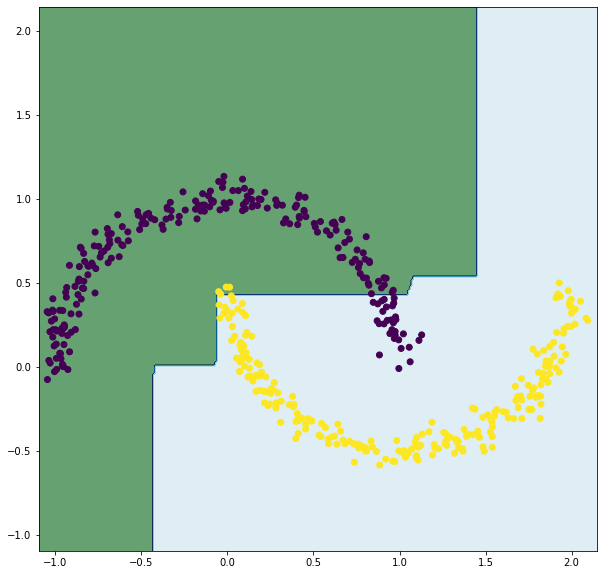

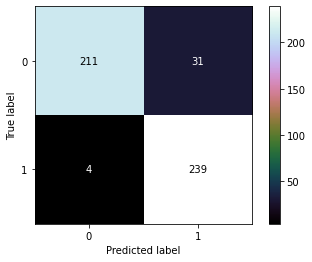

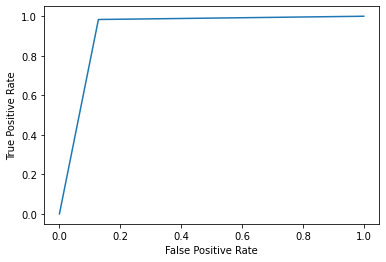

In [170]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_split=2, random_state=seed)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

Czulosc: 0.8851851851851852
Swoistosc: 0.9813953488372092
Accuracy: 0.9278350515463918
ROC auc: 0.9277199605482433
F1 score: 0.9317738791423003
BA score: 0.9277199605482433
Czas wykonania moj: 3.950404300005175


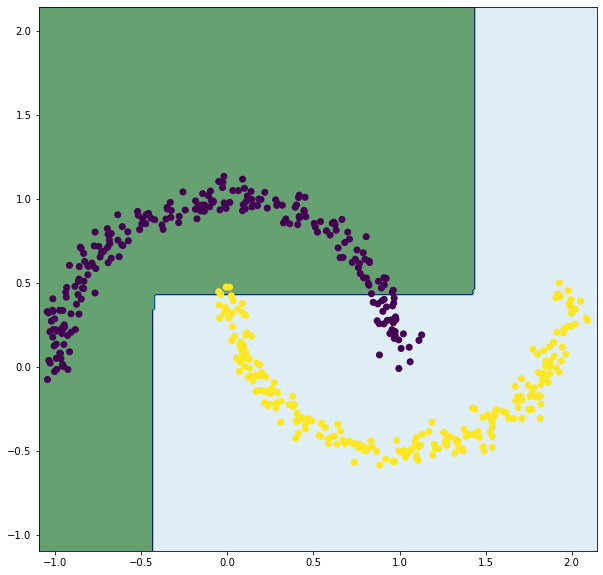

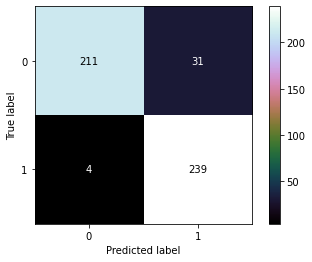

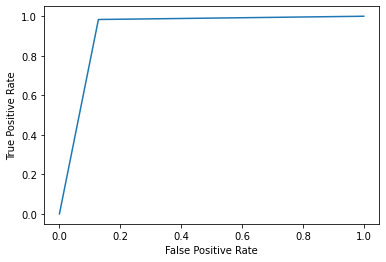

In [171]:
model = MyRandomForest(n_estimators=100, max_depth=2, min_samples_split=2)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania moj:', (time.perf_counter() - czasek))

Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0
Czas wykonania sklearn: 2.068554999976186


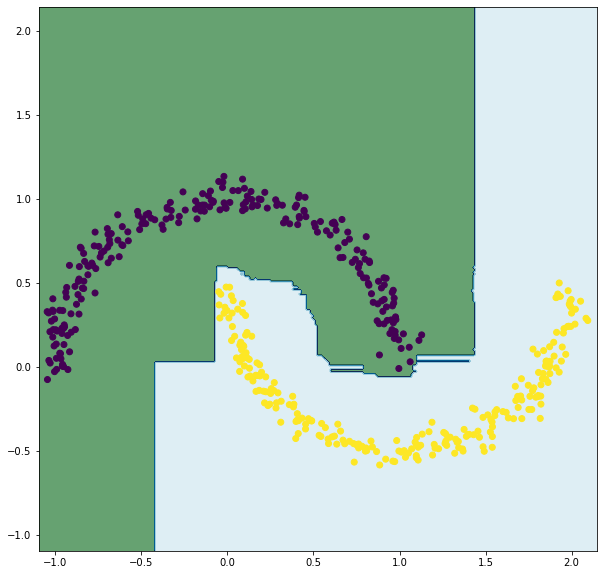

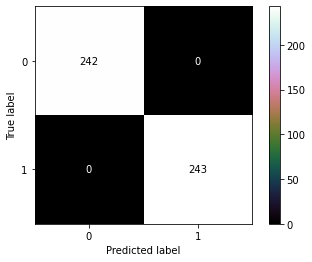

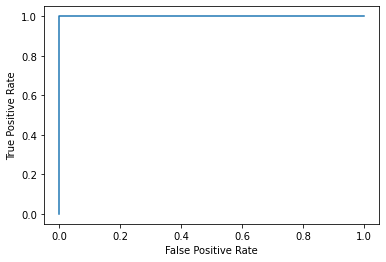

In [172]:
model = RandomForestClassifier(n_estimators=100, max_depth=samples, min_samples_split=2, random_state=seed)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0
Czas wykonania moj: 4.594900099997176


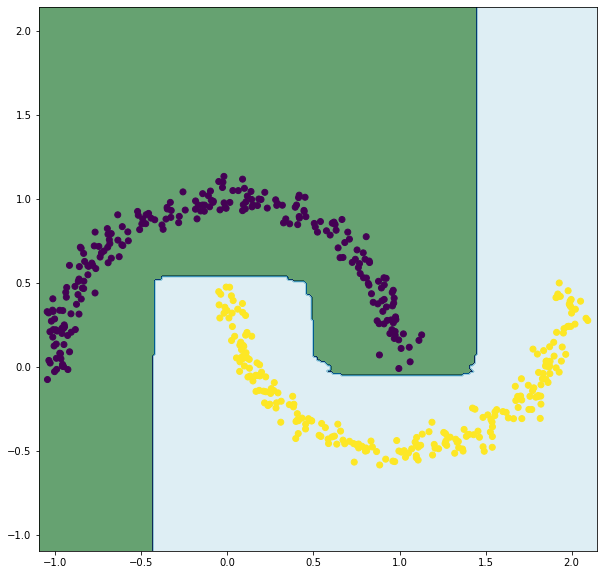

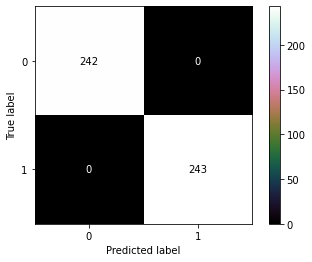

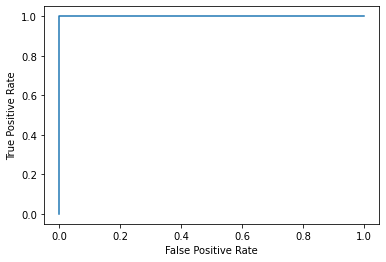

In [173]:
model = MyRandomForest(n_estimators=100, max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(9):
    tree_function(model, X_train, y_train, X_test, y_test, silent=True)
tree_function(model, X_train, y_train, X_test, y_test, xx, yy)
print('Czas wykonania moj:', (time.perf_counter() - czasek))

In [1]:
 ! jupyter nbconvert --to html lab6.ipynb

[NbConvertApp] Converting notebook lab6.ipynb to html
[NbConvertApp] Writing 2446075 bytes to lab6.html
